In [128]:
import numpy as np
import scipy.fftpack as sfft
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import h5py
import pickle
import constants as cst
from honeycomb import GetRecLatt
from LatticeInteraction import LattInter
import sys
import os
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

import Reading_Scripts as Reading
import Plotting_Scripts as Plotting
import Fourier_Transforms as Fourier
import Coulomb_Potentials as Potentials

np.set_printoptions(threshold=np.inf)

#%matplotlib widget

In [15]:
def Read_Eigen_states(fname):
    f = h5py.File(fname, "r")
    ϵ = np.array(f['eigenvalues'])
    ϕ_imag = np.array(f['evecs-imag'])
    ϕ_real = np.array(f['evecs-real'])
    f.close()
    return ϵ,ϕ_real,ϕ_imag

def Read_Density(fname):
    f = h5py.File(fname, "r")
    ψ2 = np.array(f['dens'])
    f.close()
    return ψ2

In [110]:

#fname="./../Black_P_Excitons/out_Hqpgw/24x24x24_exc.h5"
fname="./../Black_P_Excitons/out_Hqpgw_new/trial_exc.h5"
ϵ,ϕ_real,ϕ_imag =Read_Eigen_states(fname)

fname="./../Black_P_Excitons/out_Hqpgw_new/trial_exc_dens.h5"

ψ = Read_Density(fname)

In [251]:
np.where(ψ[4,:].reshape(32,32,32)==np.max(ψ[4,:].reshape(32,32,32)))
#np.max(ψ[0,:])

(array([16]), array([16]), array([17]))

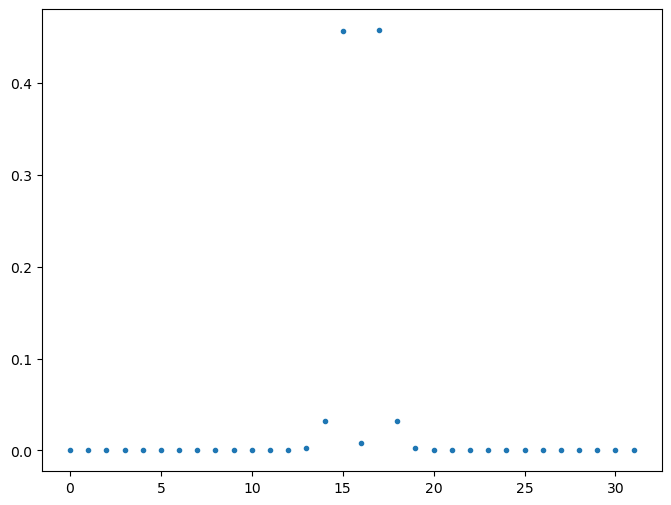

In [157]:
plt.figure(figsize=(8, 6))
#contour = plt.contourf(ψ[0,:].reshape(32,32,32)[:,:,16], cmap='viridis')
#cbar = plt.colorbar(contour)

plt.plot(ψ[1,:].reshape(32,32,32)[:,16,16],'.')

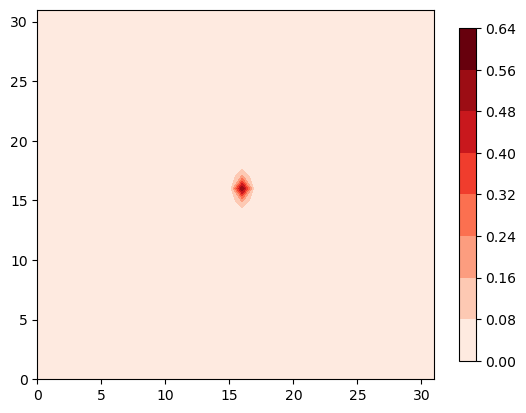

In [154]:
fig, ax = plt.subplots(1, 1)
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)  # 1.0 represents not transparent
levels = np.arange(0.0,0.6, 0.01)
levels[0] = 1e-3
norm = colors.BoundaryNorm(levels, ncolors=palette.N)


#contour = ax.imshow(ψ[0,:].reshape(32,32,32)[:,:,16],aspect='auto', cmap=palette,norm=norm)
contour = ax.contourf(ψ[0,:].reshape(32,32,32)[:,:,16], cmap=palette,norm=norm)
cbar = fig.colorbar(contour, extend='min', shrink=0.9, ax=ax)


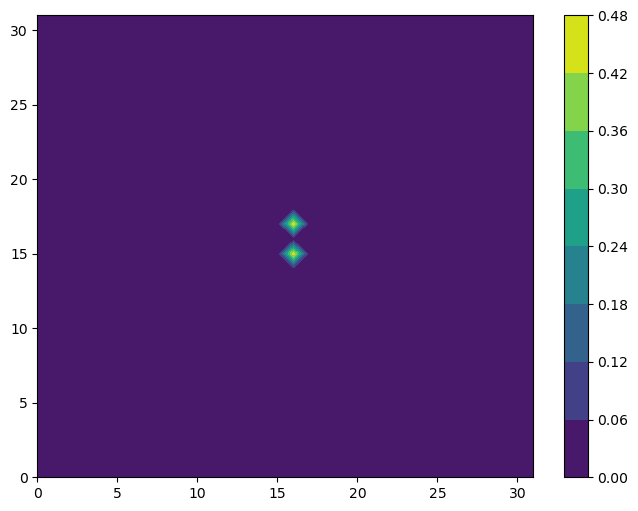

In [113]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(ψ[1,:].reshape(32,32,32)[:,:,16], cmap='viridis')
cbar = plt.colorbar(contour)

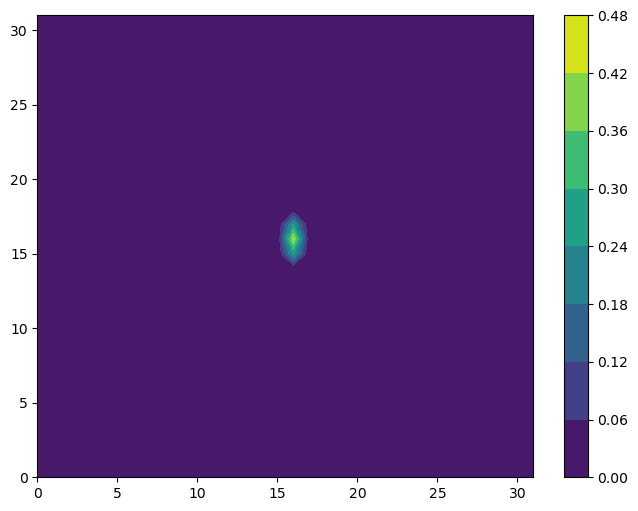

In [114]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(ψ[2,:].reshape(32,32,32)[:,:,16], cmap='viridis')
cbar = plt.colorbar(contour)

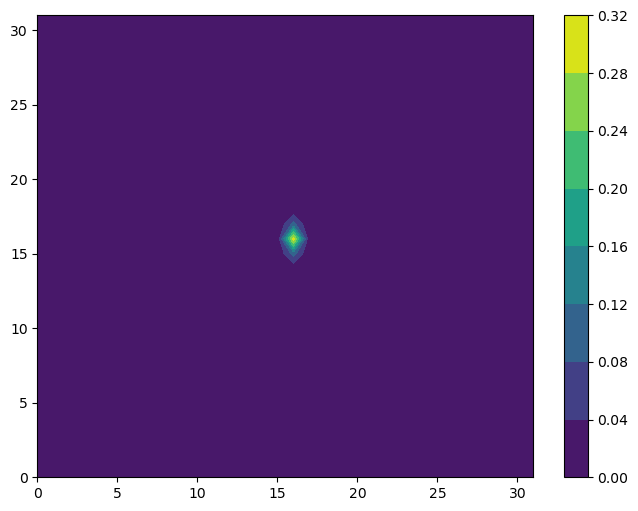

In [131]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(ψ[3,:].reshape(32,32,32)[:,:,15], cmap='viridis')
cbar = plt.colorbar(contour)

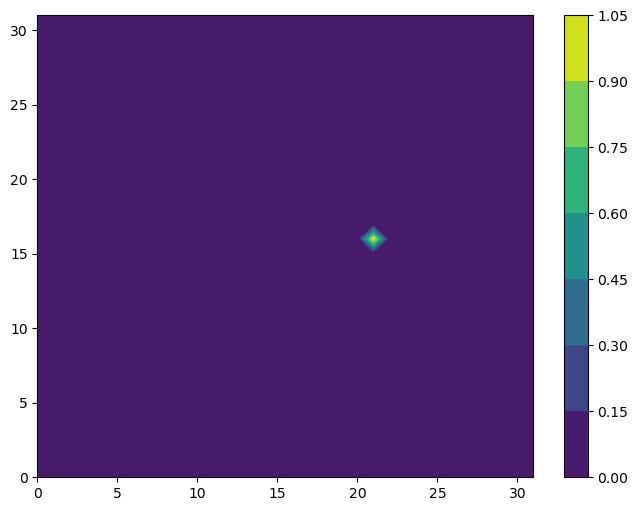

In [99]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(ψ[4,:].reshape(32,32,24)[:,:,23], cmap='viridis')
cbar = plt.colorbar(contour)

In [255]:

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


x, y = np.linspace(0, 31, 31+1), np.linspace(0, 31, 31+1)
X,Y = np.meshgrid(x,y)
fig = go.Figure(data=[go.Surface(z=ψ[1,:].reshape(32,32,32)[:,:,16], x=x, y=y,
                        colorscale='Reds',cmin=0,cmax=0.6, colorbar = dict(tickfont=dict(
                            color='black',size=30,family='Old Standard TT, serif',),orientation='h')   )])
#fig = ff.create_trisurf(z=ψ[0,:].reshape(32,32,32)[:,:,16], x=X, y=Y)

fig.update_layout(scene = dict(
                    xaxis = dict( title = ' ',
                        ticktext= [r'-1/4',r'0',r'1/4'],
                        tickvals= [8,15,23],
                        range=[7,24],tickfont=dict(
                            color='black',
                            size=17,
                            family='Old Standard TT, serif',)),
                    yaxis = dict( title = ' ',
                        ticktext= [r'-1/4',r'0',r'1/4'],
                        tickvals= [8,15,23],
                        range=[7,24],tickfont=dict(
                            color='black',
                            size=17,
                            family='Old Standard TT, serif',)) ,
                    zaxis = dict( title = ' ',
                            tickfont=dict(
                            color='black',
                            size=17,
                            family='Old Standard TT, serif',) )),
                    width=700,
                    margin=dict(r=10, l=10, b=10, t=10)
                  )


#fig.update_xaxes(range=[8, 23])
#fig.update_layout(xaxis = dict(range=[7,24]))
#fig.update_yaxes(range=[8, 23])


fig.show()